In [237]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

import shap 

np.random.seed(0)

In [238]:
def drop_cols_for_regression(df):
    drop_columns = [
        'address',
        'title',
        'listing_id',
        'property_name',
        'total_num_units',
        'available_unit_types',
        'property_details_url',
        'elevation',
        'tenure',
        'property_type',
        'floor_level',
        'furnishing',
        'built_year',
        # to remove temporarily
        'planning_area',
        'subzone', 
        # repeat 
        'population', 
        'area_size',
        # high vif 
        # 'lat', 
        # 'lng', 
        'furnishing_unspecified', 
        'property_type_private'
    ]
    """
        'gep_pri_sch_within_1km',
        'gep_pri_sch_within_1km_2km',
        'gep_pri_sch_outside_2km',
        'pri_sch_within_500m',
        'pri_sch_outside_500m',
        'line_cc',
        'line_ce',
        'line_cg',
        'line_dt',
        'line_ew',
        'line_ne',
        'line_ns',
        'line_te',
        'furnishing_partial',
        'furnishing_unfurnished',
        'furnishing_unspecified',
    ]
    """
    return df.drop(columns=drop_columns)

In [239]:
# load data set
df = pd.read_csv('../data/train.csv')
adfs = read_aux_csv('../data')
df = join_aux(df, adfs)
df = preprocess(df)
df = drop_cols_for_regression(df)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer.fit(df[['region']])
df[categorical_transformer.categories_[0]] = categorical_transformer.transform(df[['region']]).toarray()
df = df.drop(columns=['region'])

In [240]:
df.head(1)

,num_beds,num_baths,size_sqft,lat,lng,price,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,...,floor_level_mid,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,c,e,n,ne,w
0,3.0,2.0,1184,1.2819,103.825948,1081500.0,0.49163,0,0,0,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [241]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


In [242]:
df['psf'] = df['price'] / df['size_sqft']
cols = ['nearest_pri_sch_distance_in_km', 'psf'] 

cluster_df = df.copy()
scaler = StandardScaler()
cluster_df[cols] = scaler.fit_transform(cluster_df[cols])

# ax = plt.axes(projection='3d')
# ax.scatter3D(cluster_df[cols[0]], cluster_df[cols[1]], cluster_df[cols[2]], c=dbscan_places.labels_)
# plt.show()

scaling because distance matters

In [243]:

cluster_df = df.copy()

scaler = StandardScaler()
cluster_df[df.columns] = scaler.fit_transform(cluster_df[df.columns])

cluster_df = cluster_df.drop(columns=['price'])

pca 

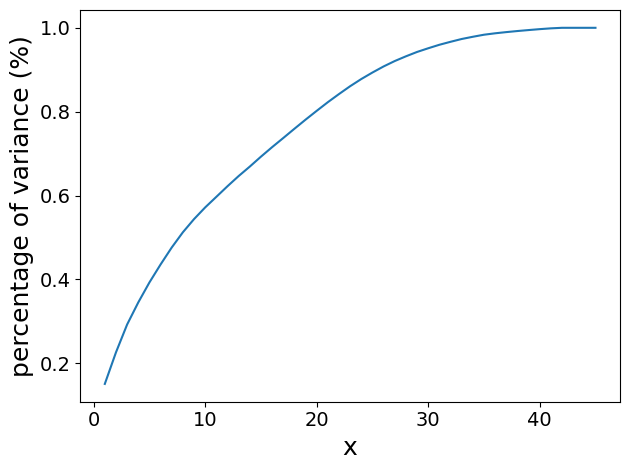

CPU times: user 19.7 s, sys: 28.9 s, total: 48.7 s
Wall time: 10.8 s


In [244]:
%%time

x_vals, y_vals = [], []

for n in range(1, len(cluster_df.columns)):
    
    pca = PCA(n_components=n).fit(cluster_df)

    x_vals.append(n)
    y_vals.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure()
plt.tick_params(labelsize=14)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.ylabel('percentage of variance (%)')
plt.plot(x_vals, y_vals)
plt.tight_layout()
plt.show()

In [246]:
pca = PCA(n_components=2).fit(cluster_df)

print('Overall explained variance: {:.3f}'.format(np.sum(pca.explained_variance_ratio_)))

X_pca = pca.transform(cluster_df)

Overall explained variance: 0.226


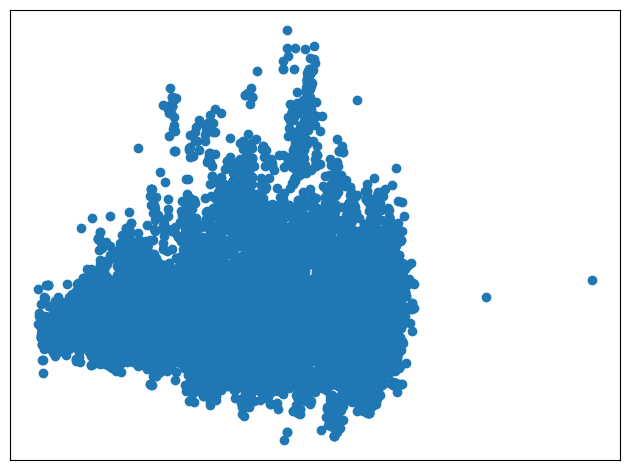

In [247]:
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

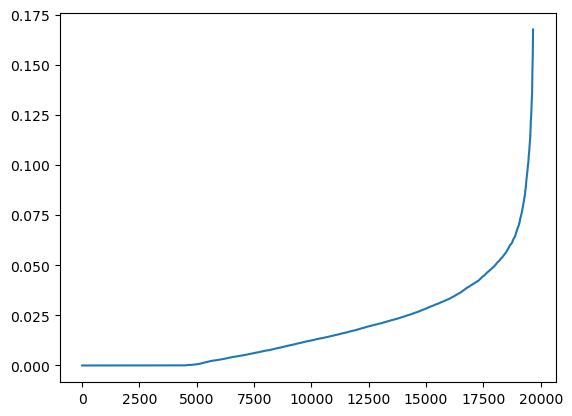

In [248]:
neighbors = NearestNeighbors(n_neighbors=100)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances[:-100])
plt.show()

In [223]:
X_dbscan = DBSCAN(eps=0.075, min_samples=100).fit(X_pca)

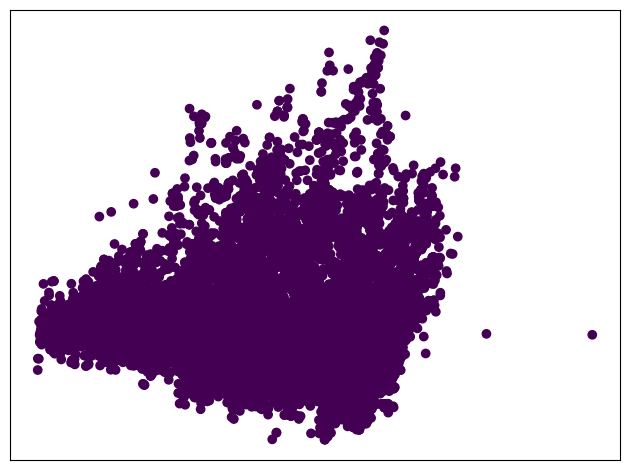

In [224]:
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_dbscan.labels_)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

In [222]:
# all points classified as noise 
X_dbscan.labels_[X_dbscan.labels_ > -1]

array([], dtype=int64)

tsne

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


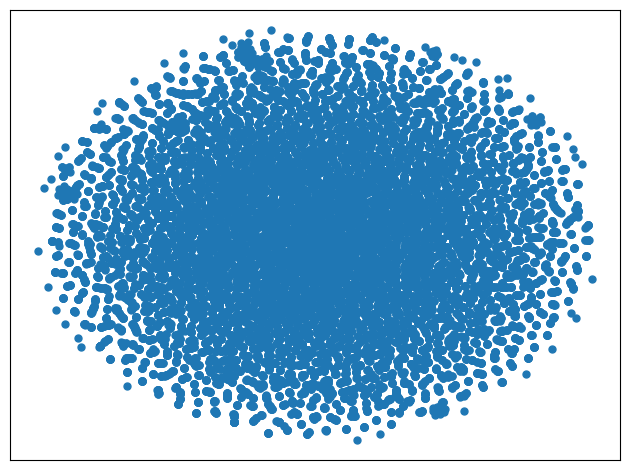

In [228]:
X_tsne = TSNE(n_components=2, perplexity=5).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


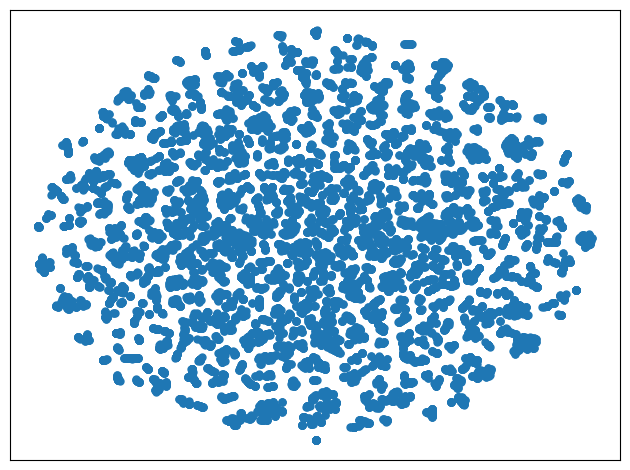

In [231]:
X_tsne = TSNE(n_components=2, perplexity=20).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


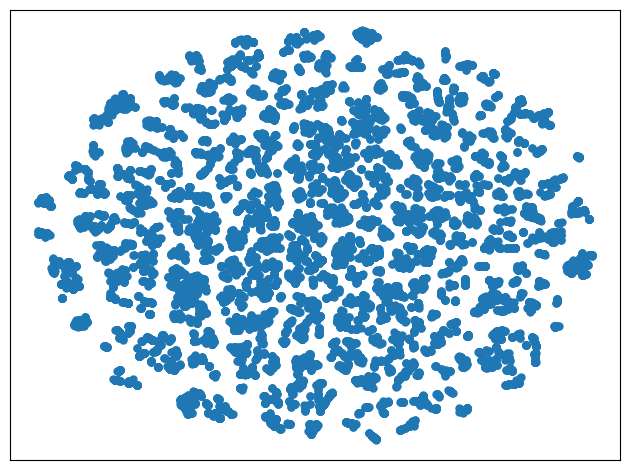

In [232]:
X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


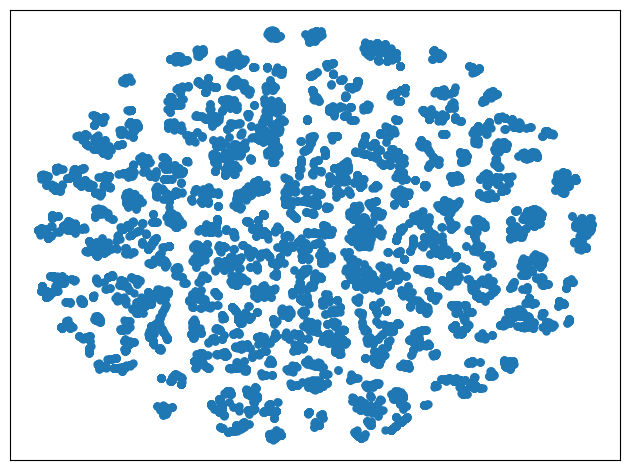

In [233]:
X_tsne = TSNE(n_components=2, perplexity=40).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


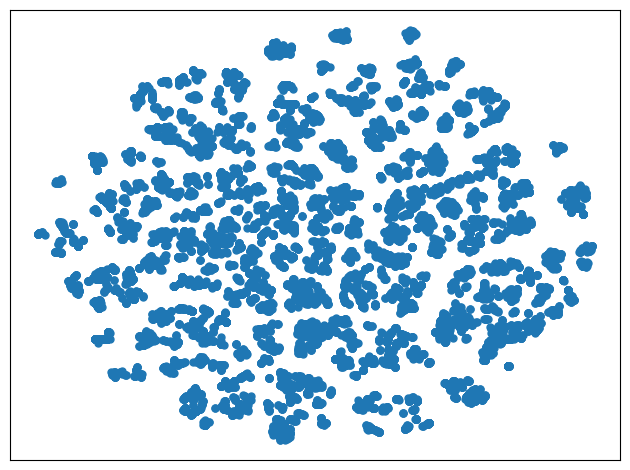

In [229]:
X_tsne = TSNE(n_components=2, perplexity=50).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


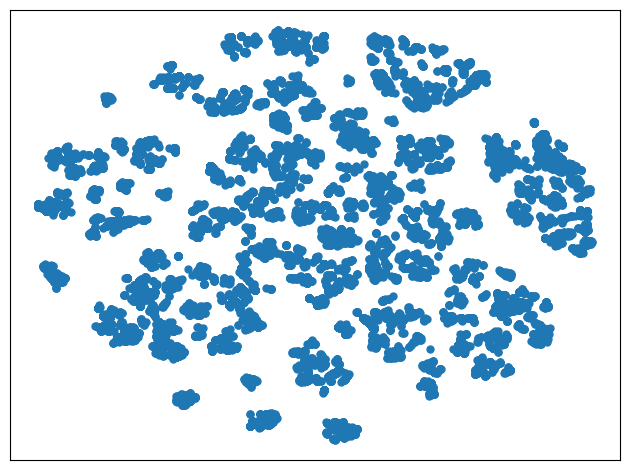

In [225]:
X_tsne = TSNE(n_components=2, perplexity=100).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


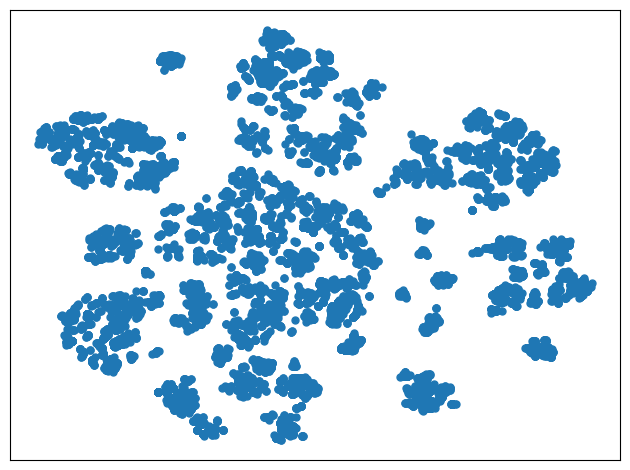

In [226]:
X_tsne = TSNE(n_components=2, perplexity=200).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


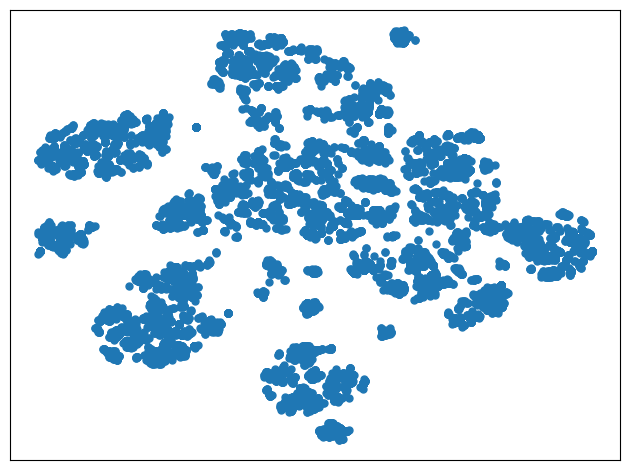

In [227]:
X_tsne = TSNE(n_components=2, perplexity=300).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


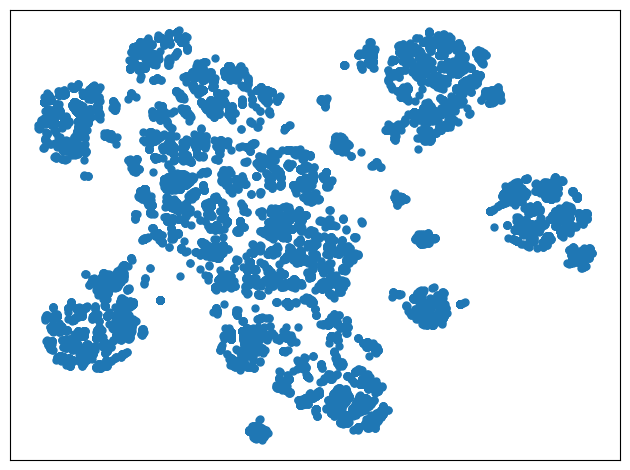

In [249]:
X_tsne = TSNE(n_components=2, perplexity=500).fit_transform(cluster_df)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()